# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

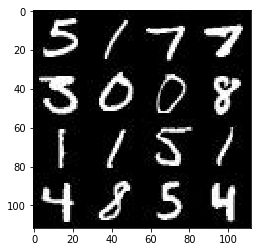

In [2]:
show_n_images = 20

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

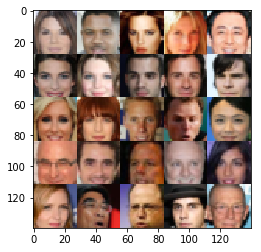

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [43]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_dim = (image_width ,image_height, image_channels)
    input_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/usr/lo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2, training=True):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x = tf.layers.conv2d(images, 56, 5, strides=(2, 2), padding='same')
        # Leaky ReLU
        x = tf.maximum(x * alpha, x)
        # Now 14x14x56
        
        x = tf.layers.conv2d(x, 112, 5, strides=(2, 2), padding='same')
        x = tf.layers.batch_normalization(x, training=training)
        x = tf.maximum(x * alpha, x)
        # Now 7x7x112
        
        # Flatten to 1D tensor
        x = tf.reshape(x, (-1, 7 * 7 * 112))
        logits = tf.layers.dense(x, 1)
        output = tf.nn.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse= not is_train):
        x = tf.layers.dense(z, 7 * 7 * 256)
        # Reshape tensor with -1 to flaten into a 1d
        x = tf.reshape(x, (-1, 7, 7, 256))
        # Batch Norm
        x = tf.layers.batch_normalization(x, training=is_train)
        # Leaky ReLU
        x = tf.maximum(x * alpha, x)
        # now 7x7x256
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=(2, 2), padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x * alpha, x)
        # now 14x14x128
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=(2, 2), padding='same')
        output = tf.tanh(logits)
        # now 28x28x3
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    alpha=0.2
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [69]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # TODO: Build Model    
    # Reset number of steps
    samples, losses = [], []
    steps = 0
    
    # Print training data
    print_every = 10
    show_every = 100
    
    
    # Pass dim 3 or 1 depending if images have color or not
    if (data_image_mode == 'RGB'):
        out_channel_dim=3
    else:
        out_channel_dim=1
    
    
    # Add placeholder to indicate whether or not we're training the model
    is_training = tf.placeholder(tf.bool)
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    lr = learning_rate
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
 
    # Train and test the network
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 
                # dimensional images fot fit our random uniform we multiply by 1.
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(input_z, out_channel_dim, is_train=False),
                                   feed_dict={input_z: batch_z})
                    samples.append(gen_samples)
                    show_generator_output(sess, 10, input_z, data_shape[3], data_image_mode)


        show_generator_output(sess, 10, input_z, data_shape[3], data_image_mode)
        return losses, samples
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1808... Generator Loss: 5.4378
Epoch 1/2... Discriminator Loss: 0.2299... Generator Loss: 2.7963
Epoch 1/2... Discriminator Loss: 0.3349... Generator Loss: 3.0191
Epoch 1/2... Discriminator Loss: 0.6116... Generator Loss: 3.5508
Epoch 1/2... Discriminator Loss: 0.7991... Generator Loss: 1.3067
Epoch 1/2... Discriminator Loss: 1.6007... Generator Loss: 0.7089
Epoch 1/2... Discriminator Loss: 1.1412... Generator Loss: 1.2792
Epoch 1/2... Discriminator Loss: 1.1957... Generator Loss: 1.3212
Epoch 1/2... Discriminator Loss: 1.6046... Generator Loss: 2.2709
Epoch 1/2... Discriminator Loss: 1.6688... Generator Loss: 2.0954


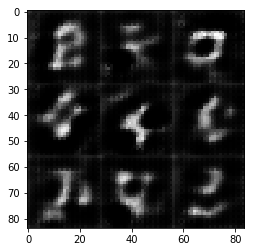

Epoch 1/2... Discriminator Loss: 1.2402... Generator Loss: 0.9002
Epoch 1/2... Discriminator Loss: 1.4997... Generator Loss: 0.3882
Epoch 1/2... Discriminator Loss: 1.4193... Generator Loss: 0.4743
Epoch 1/2... Discriminator Loss: 2.3723... Generator Loss: 1.9194
Epoch 1/2... Discriminator Loss: 1.2561... Generator Loss: 1.6394
Epoch 1/2... Discriminator Loss: 1.2893... Generator Loss: 0.9064
Epoch 1/2... Discriminator Loss: 1.3629... Generator Loss: 1.1256
Epoch 1/2... Discriminator Loss: 1.1544... Generator Loss: 1.4723
Epoch 1/2... Discriminator Loss: 1.5366... Generator Loss: 1.6742
Epoch 1/2... Discriminator Loss: 1.9361... Generator Loss: 0.2464


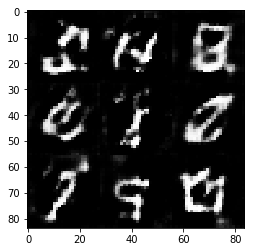

Epoch 1/2... Discriminator Loss: 1.0926... Generator Loss: 1.0968
Epoch 1/2... Discriminator Loss: 1.4766... Generator Loss: 0.3634
Epoch 1/2... Discriminator Loss: 1.3547... Generator Loss: 0.4349
Epoch 1/2... Discriminator Loss: 1.0716... Generator Loss: 0.7586
Epoch 1/2... Discriminator Loss: 1.1287... Generator Loss: 0.8252
Epoch 1/2... Discriminator Loss: 1.1793... Generator Loss: 0.8631
Epoch 1/2... Discriminator Loss: 1.0801... Generator Loss: 0.8495
Epoch 1/2... Discriminator Loss: 1.3349... Generator Loss: 0.4528
Epoch 1/2... Discriminator Loss: 1.1358... Generator Loss: 0.9276
Epoch 1/2... Discriminator Loss: 1.0097... Generator Loss: 1.3220


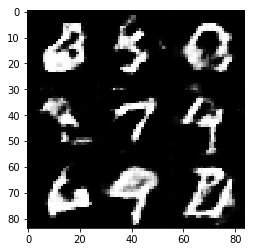

Epoch 1/2... Discriminator Loss: 1.4305... Generator Loss: 1.1729
Epoch 1/2... Discriminator Loss: 1.4062... Generator Loss: 1.7581
Epoch 1/2... Discriminator Loss: 1.4097... Generator Loss: 0.4230
Epoch 1/2... Discriminator Loss: 1.2715... Generator Loss: 0.5252
Epoch 1/2... Discriminator Loss: 1.2778... Generator Loss: 0.4646
Epoch 1/2... Discriminator Loss: 1.1636... Generator Loss: 1.2647
Epoch 1/2... Discriminator Loss: 1.5159... Generator Loss: 0.3708
Epoch 1/2... Discriminator Loss: 1.4589... Generator Loss: 0.3777
Epoch 1/2... Discriminator Loss: 1.2330... Generator Loss: 1.0767
Epoch 1/2... Discriminator Loss: 1.2923... Generator Loss: 0.5169


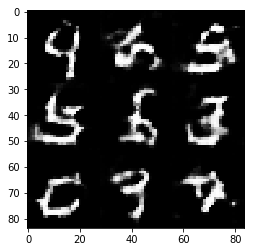

Epoch 1/2... Discriminator Loss: 1.6182... Generator Loss: 0.3122
Epoch 1/2... Discriminator Loss: 1.2602... Generator Loss: 0.5194
Epoch 1/2... Discriminator Loss: 1.2836... Generator Loss: 0.5220
Epoch 1/2... Discriminator Loss: 1.1868... Generator Loss: 0.6962
Epoch 1/2... Discriminator Loss: 1.5510... Generator Loss: 0.4611
Epoch 1/2... Discriminator Loss: 1.2522... Generator Loss: 0.7077
Epoch 1/2... Discriminator Loss: 1.1638... Generator Loss: 0.8820
Epoch 1/2... Discriminator Loss: 1.2976... Generator Loss: 0.4734
Epoch 1/2... Discriminator Loss: 1.0396... Generator Loss: 0.8808
Epoch 1/2... Discriminator Loss: 1.7151... Generator Loss: 0.3208


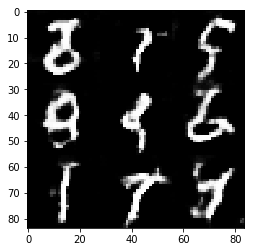

Epoch 1/2... Discriminator Loss: 1.3290... Generator Loss: 0.4263
Epoch 1/2... Discriminator Loss: 1.2161... Generator Loss: 0.6036
Epoch 1/2... Discriminator Loss: 1.2532... Generator Loss: 1.3760
Epoch 1/2... Discriminator Loss: 1.0805... Generator Loss: 0.9844
Epoch 1/2... Discriminator Loss: 0.9493... Generator Loss: 0.9669
Epoch 1/2... Discriminator Loss: 1.3692... Generator Loss: 0.5035
Epoch 1/2... Discriminator Loss: 1.4992... Generator Loss: 0.4766
Epoch 1/2... Discriminator Loss: 1.1331... Generator Loss: 0.8322
Epoch 1/2... Discriminator Loss: 1.3530... Generator Loss: 0.8148
Epoch 1/2... Discriminator Loss: 1.3401... Generator Loss: 0.4948


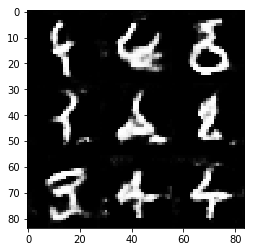

Epoch 2/2... Discriminator Loss: 1.1384... Generator Loss: 0.6420
Epoch 2/2... Discriminator Loss: 1.0282... Generator Loss: 0.8347
Epoch 2/2... Discriminator Loss: 1.3456... Generator Loss: 0.5854
Epoch 2/2... Discriminator Loss: 1.4449... Generator Loss: 0.4257
Epoch 2/2... Discriminator Loss: 1.2658... Generator Loss: 0.5422
Epoch 2/2... Discriminator Loss: 1.2854... Generator Loss: 1.6194
Epoch 2/2... Discriminator Loss: 1.3061... Generator Loss: 1.5064
Epoch 2/2... Discriminator Loss: 1.2190... Generator Loss: 1.4543
Epoch 2/2... Discriminator Loss: 1.1140... Generator Loss: 1.1505
Epoch 2/2... Discriminator Loss: 2.0466... Generator Loss: 2.5625


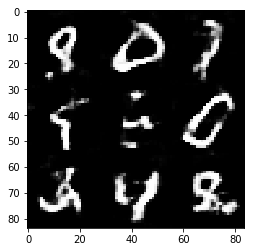

Epoch 2/2... Discriminator Loss: 1.2917... Generator Loss: 1.4471
Epoch 2/2... Discriminator Loss: 1.1852... Generator Loss: 0.7942
Epoch 2/2... Discriminator Loss: 1.1409... Generator Loss: 1.0229
Epoch 2/2... Discriminator Loss: 1.2563... Generator Loss: 0.6431
Epoch 2/2... Discriminator Loss: 1.3339... Generator Loss: 0.4205
Epoch 2/2... Discriminator Loss: 1.3879... Generator Loss: 0.8884
Epoch 2/2... Discriminator Loss: 1.2723... Generator Loss: 1.4322
Epoch 2/2... Discriminator Loss: 1.1719... Generator Loss: 0.6080
Epoch 2/2... Discriminator Loss: 1.2245... Generator Loss: 0.5694
Epoch 2/2... Discriminator Loss: 2.9377... Generator Loss: 2.5348


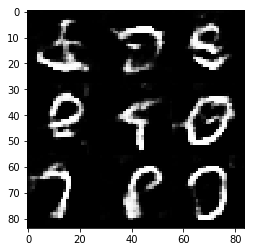

Epoch 2/2... Discriminator Loss: 1.4900... Generator Loss: 0.3924
Epoch 2/2... Discriminator Loss: 1.3172... Generator Loss: 0.4654
Epoch 2/2... Discriminator Loss: 1.1647... Generator Loss: 0.7102
Epoch 2/2... Discriminator Loss: 1.3067... Generator Loss: 0.4953
Epoch 2/2... Discriminator Loss: 1.1458... Generator Loss: 0.8634
Epoch 2/2... Discriminator Loss: 1.6760... Generator Loss: 1.7389
Epoch 2/2... Discriminator Loss: 1.3254... Generator Loss: 0.5986
Epoch 2/2... Discriminator Loss: 1.2721... Generator Loss: 1.6835
Epoch 2/2... Discriminator Loss: 1.0580... Generator Loss: 1.0624
Epoch 2/2... Discriminator Loss: 1.1604... Generator Loss: 0.8966


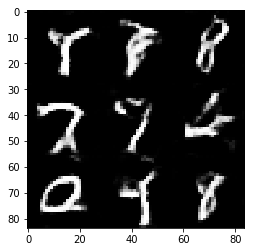

Epoch 2/2... Discriminator Loss: 1.5650... Generator Loss: 1.8363
Epoch 2/2... Discriminator Loss: 1.2215... Generator Loss: 0.6068
Epoch 2/2... Discriminator Loss: 1.1609... Generator Loss: 0.5984
Epoch 2/2... Discriminator Loss: 1.3382... Generator Loss: 0.7570
Epoch 2/2... Discriminator Loss: 1.0945... Generator Loss: 1.1614
Epoch 2/2... Discriminator Loss: 1.1650... Generator Loss: 1.0070
Epoch 2/2... Discriminator Loss: 1.0911... Generator Loss: 0.6047
Epoch 2/2... Discriminator Loss: 1.1054... Generator Loss: 0.8370
Epoch 2/2... Discriminator Loss: 1.1167... Generator Loss: 1.4272
Epoch 2/2... Discriminator Loss: 0.9677... Generator Loss: 1.1984


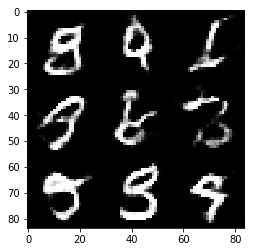

Epoch 2/2... Discriminator Loss: 1.2936... Generator Loss: 0.8352
Epoch 2/2... Discriminator Loss: 1.5318... Generator Loss: 1.7116
Epoch 2/2... Discriminator Loss: 1.0555... Generator Loss: 0.8351
Epoch 2/2... Discriminator Loss: 1.2795... Generator Loss: 1.7983
Epoch 2/2... Discriminator Loss: 1.1550... Generator Loss: 1.8357
Epoch 2/2... Discriminator Loss: 1.1303... Generator Loss: 0.6276
Epoch 2/2... Discriminator Loss: 1.0083... Generator Loss: 0.8975
Epoch 2/2... Discriminator Loss: 1.1180... Generator Loss: 0.6437
Epoch 2/2... Discriminator Loss: 1.2151... Generator Loss: 0.6012
Epoch 2/2... Discriminator Loss: 1.3652... Generator Loss: 0.4023


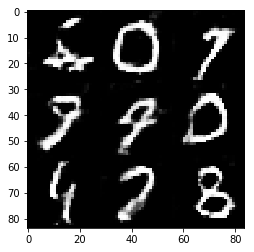

Epoch 2/2... Discriminator Loss: 1.0730... Generator Loss: 1.5511
Epoch 2/2... Discriminator Loss: 1.5232... Generator Loss: 0.9242
Epoch 2/2... Discriminator Loss: 1.4163... Generator Loss: 1.0800
Epoch 2/2... Discriminator Loss: 1.0581... Generator Loss: 0.9608
Epoch 2/2... Discriminator Loss: 1.2160... Generator Loss: 1.5657
Epoch 2/2... Discriminator Loss: 1.1665... Generator Loss: 0.7453
Epoch 2/2... Discriminator Loss: 1.0235... Generator Loss: 0.9015
Epoch 2/2... Discriminator Loss: 1.1047... Generator Loss: 1.0364
Epoch 2/2... Discriminator Loss: 0.9854... Generator Loss: 0.8578
Epoch 2/2... Discriminator Loss: 2.0992... Generator Loss: 0.1989


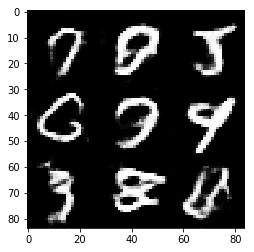

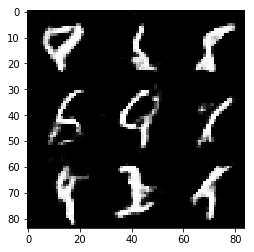

In [70]:
batch_size = 100
z_dim = 100
learning_rate = 0.002
beta1 = 0.5

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses, samples = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

In [71]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

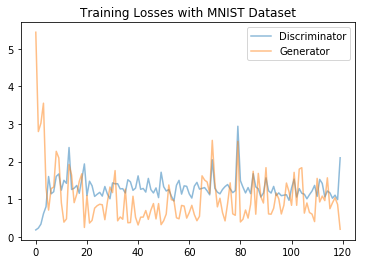

In [72]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses with MNIST Dataset")
plt.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.2829... Generator Loss: 0.0685
Epoch 1/1... Discriminator Loss: 2.6138... Generator Loss: 0.1529
Epoch 1/1... Discriminator Loss: 2.0332... Generator Loss: 0.4038
Epoch 1/1... Discriminator Loss: 1.9429... Generator Loss: 0.5050
Epoch 1/1... Discriminator Loss: 1.7106... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.6570... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.5785... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.6715... Generator Loss: 0.6879


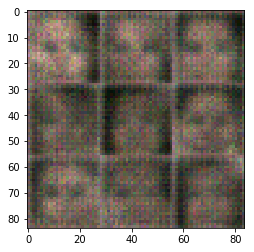

Epoch 1/1... Discriminator Loss: 1.5138... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.5428... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.5783... Generator Loss: 0.6366
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.4837... Generator Loss: 0.6056
Epoch 1/1... Discriminator Loss: 1.5754... Generator Loss: 0.5482
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.8750


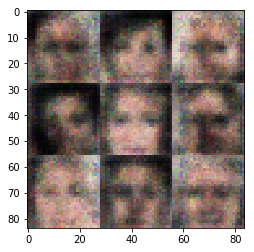

Epoch 1/1... Discriminator Loss: 1.5419... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 1.4876... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 1.5211... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.5168... Generator Loss: 0.5984
Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.8576


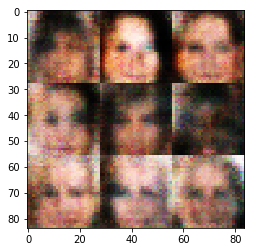

Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 1.1096
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 0.5788
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 0.8156


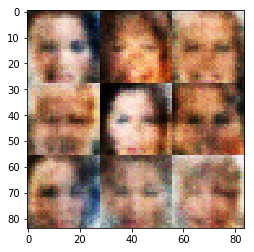

Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.6195
Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 0.9748
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.4731
Epoch 1/1... Discriminator Loss: 1.2341... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.8559
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.5866
Epoch 1/1... Discriminator Loss: 1.1854... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 1.0094


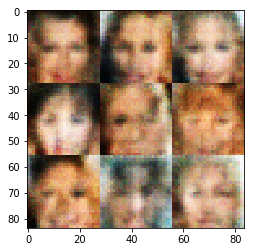

Epoch 1/1... Discriminator Loss: 1.2790... Generator Loss: 1.0058
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.5708
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.9407
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 1.0651
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.6002
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.5808
Epoch 1/1... Discriminator Loss: 1.1762... Generator Loss: 0.9956
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.9523


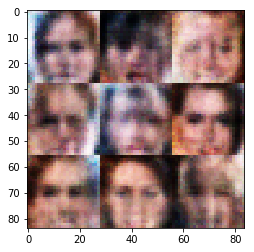

Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.6382
Epoch 1/1... Discriminator Loss: 1.1799... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.5401
Epoch 1/1... Discriminator Loss: 1.0364... Generator Loss: 1.0676
Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.1765... Generator Loss: 0.9956
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.8097


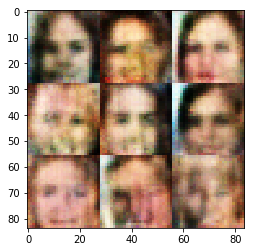

Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.5084
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 0.9269... Generator Loss: 1.0858
Epoch 1/1... Discriminator Loss: 0.9591... Generator Loss: 1.0024
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 0.9520
Epoch 1/1... Discriminator Loss: 1.0192... Generator Loss: 1.0598
Epoch 1/1... Discriminator Loss: 1.2147... Generator Loss: 0.9319
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 1.3997
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.4756


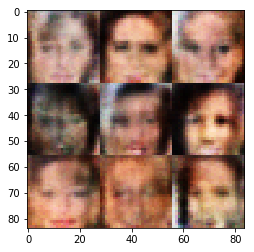

Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 1.2392
Epoch 1/1... Discriminator Loss: 1.2116... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 1.0347
Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 0.9958
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 1.0718
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 1.1360
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 1.5759
Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 1.0924


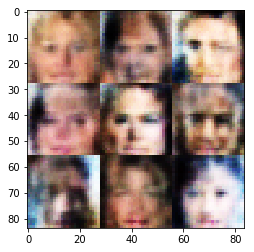

Epoch 1/1... Discriminator Loss: 1.0650... Generator Loss: 0.9478
Epoch 1/1... Discriminator Loss: 1.7153... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 2.1216... Generator Loss: 0.2189
Epoch 1/1... Discriminator Loss: 1.5427... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.6062... Generator Loss: 0.5746
Epoch 1/1... Discriminator Loss: 1.6541... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.5331... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.6995... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.4988... Generator Loss: 0.6947


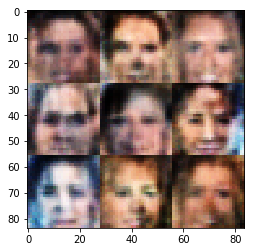

Epoch 1/1... Discriminator Loss: 1.6833... Generator Loss: 0.5912
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 1.6395... Generator Loss: 0.5472
Epoch 1/1... Discriminator Loss: 1.5052... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.6348
Epoch 1/1... Discriminator Loss: 1.4783... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.6349
Epoch 1/1... Discriminator Loss: 1.5964... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.6465


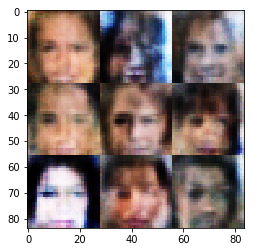

Epoch 1/1... Discriminator Loss: 1.5245... Generator Loss: 0.6438
Epoch 1/1... Discriminator Loss: 1.4988... Generator Loss: 0.6583
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.5924... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.6131... Generator Loss: 0.6324
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.5071... Generator Loss: 0.6496
Epoch 1/1... Discriminator Loss: 1.4759... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.6631


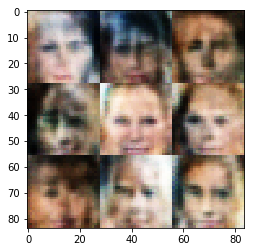

Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 1.5540... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.4778... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.6953


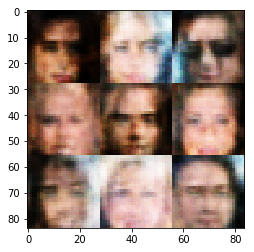

Epoch 1/1... Discriminator Loss: 1.4782... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.3026... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.4822... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.7340


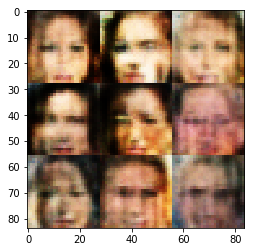

Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.5014... Generator Loss: 0.6742
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.7009


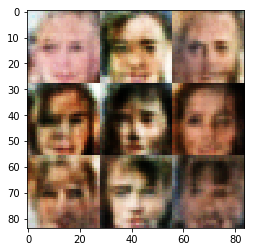

Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.5123... Generator Loss: 0.6500


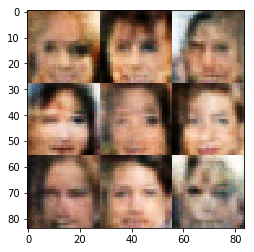

In [73]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses, samples = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

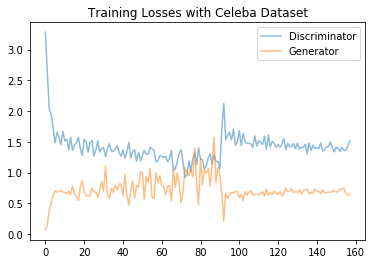

In [74]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses with Celeba Dataset")
plt.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.